In [ ]:
# para que podemos usar las maquinas de soporte vectorial para clasficar, vamos a hacer un ejemplo con reconocimento facial

# Reconocimiento Facial

In [1]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt

In [2]:
faces = fetch_lfw_people(min_faces_per_person=60)

In [3]:
print(faces.target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']


In [4]:
print(faces.images.shape)    #cada imagen tiene 62 pixels de alto y 47 de lado

(1348, 62, 47)


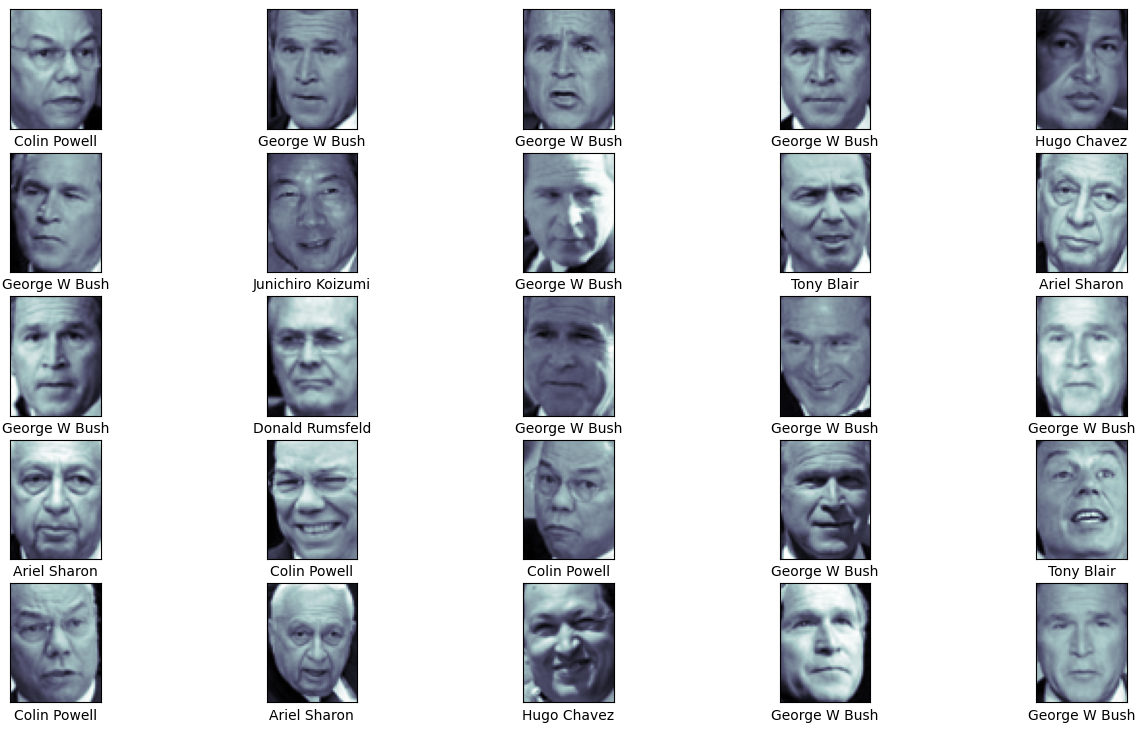

In [9]:
fig, ax = plt.subplots(5,5, figsize=(16,9))
for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(faces.images[i], cmap="bone")
    ax_i.set(xticks=[], yticks=[],xlabel=faces.target_names[faces.target[i]])

In [10]:
62*47 # tiene unos 3000 pixels; entonces podríamos utilizar cada pixel como rasgo a clasificar, ojo, tendriamos un espacio vectorial de 2914 dimensiones. esto no sería muy efectivo, entonces usamos un truco de procesado, usamos una técnica que reduzca de 2914 a unos 150

2914

In [17]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline     # pipeline: para hacer primero uno y luego el otro (verlo abajo)

In [18]:
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)     # random_state hemos puesto 42 (pero se lo ha inventado)
svc = SVC(kernel="rbf", class_weight="balanced")
model = make_pipeline(pca, svc)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(faces.data, faces.target, random_state = 42)

In [22]:
from sklearn.model_selection import GridSearchCV     #  "from sklearn.grid_search import GridSearchCV" este ya no funciona

In [23]:
param_grid = {
    "svc__C":[0.1,1,5,10,50],
    "svc__gamma":[0.0001, 0.0005, 0.001, 0.005, 0.01]
}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, Ytrain)

CPU times: user 1min 23s, sys: 1min 1s, total: 2min 25s
Wall time: 1min 29s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.1, 1, 5, 10, 50],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]})

In [24]:
print(grid.best_params_)    #estos son los mejores C y gamma  (ojo, si nos da que C y gamma están en los extremos de los rangos que hemos puesto arriba, deberíamos repetir el experimento expandiendo los rangos) asímismo, si me ha dado 5, podemos hacerlo de nuevo poniendo el rango por ejemplo 3,4,5,6,7 y lo mismo con gamma para ajustar mejor todavia

{'svc__C': 5, 'svc__gamma': 0.001}


In [25]:
classifier = grid.best_estimator_
yfit = classifier.predict(Xtest)

Text(0.5, 0.98, 'Predicciones de las imágenes (incorrectas en rojo)')

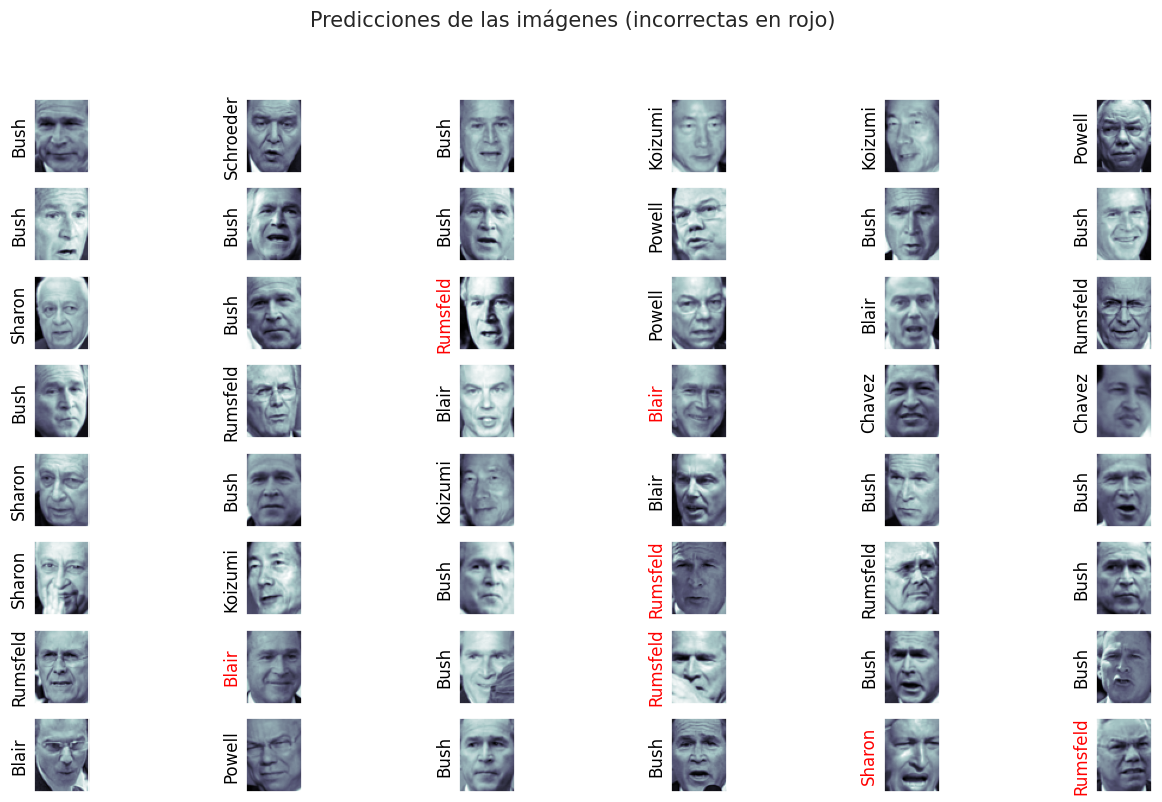

In [33]:
fig, ax = plt.subplots(8,6,figsize=(16,9))

for i, ax_i in enumerate(ax.flat):
    ax_i.imshow(Xtest[i].reshape(62,47), cmap="bone")
    ax_i.set(xticks=[], yticks=[])
    ax_i.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color = "black" if yfit[i]==Ytest[i] else "red")

fig.suptitle("Predicciones de las imágenes (incorrectas en rojo)", size = 15)

In [27]:
from sklearn.metrics import classification_report

In [28]:
print(classification_report(Ytest, yfit, target_names = faces.target_names))    # recall: 1 menos falsos negativos; f1 = precision / recall

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



In [29]:
from sklearn.metrics import confusion_matrix

In [30]:
mat = confusion_matrix(Ytest, yfit)

In [31]:
import seaborn as sns; sns.set()

<Axes: >

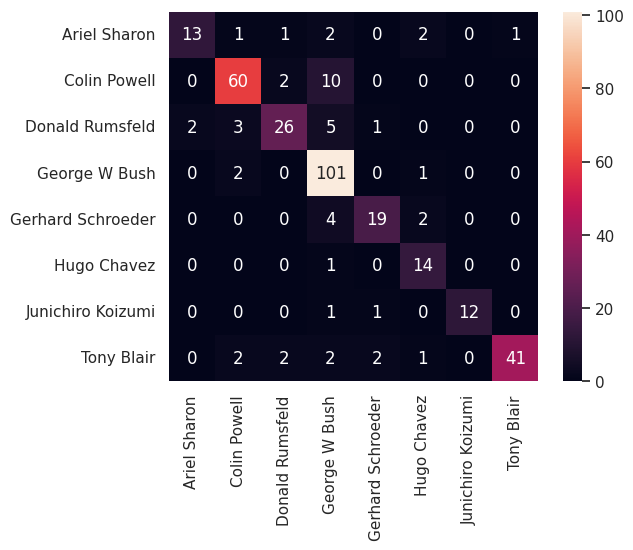

In [32]:
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, 
            xticklabels=faces.target_names, yticklabels=faces.target_names )